In [108]:
import datetime

import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import cv2 
tf.disable_v2_behavior()

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt 

In [109]:
np.set_printoptions(linewidth=500)

In [145]:
TRAIN_DATA_PATH = "data/Q1_train.csv"
TEST_DATA_PATH = "data/Q1_test.csv"

SIZE_IN_ROW = 28
VALIDATION_PERCNTAGE = 0.2

LABELS = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',
          12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',
          19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y'}


WIDTH = 28
HEIGHT = 28

In [111]:
all_data = pd.read_csv(TRAIN_DATA_PATH,index_col=False)
test_data = pd.read_csv(TEST_DATA_PATH,index_col=False)

In [112]:
all_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [113]:
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [114]:
def disp_images(data):
    fig, axes = plt.subplots(5, 5)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i][1:].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(LABELS[data[i][0]])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.gcf().set_facecolor("white")
    plt.show()
    
    

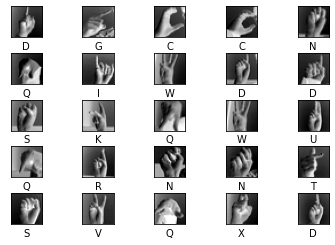

In [115]:
disp_images(all_data.iloc[0:25].values)

In [116]:
## random shuffling first time
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

## Train and Validation splitting

after one random shuffling , split train and validation data from all data

In [117]:
data_length = all_data.shape[0]
test_data_length = test_data.shape[0]
print("all train + validate data lengths: " + str(data_length))
validation_data_length = int(data_length * VALIDATION_PERCNTAGE)
train_data_length = data_length - validation_data_length

print("train data lengths: " + str(train_data_length) +
      "\r\nvalidate data lengths : " + str(validation_data_length))

all train + validate data lengths: 27455
train data lengths: 21964
validate data lengths : 5491


In [118]:
y_labels = all_data['label']
all_data = all_data.drop('label',1)

y_test_labels = test_data['label']
test_data = test_data.drop('label',1)


/tmp/ipykernel_32663/1524214916.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  all_data = all_data.drop('label',1)
/tmp/ipykernel_32663/1524214916.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_data = test_data.drop('label',1)


In [119]:
## DATA normalization and encoding Y

x_train = 2 * (all_data.copy().values[:train_data_length].astype(np.float32)/255 - 0.5)
_y_train = y_labels.copy()[:train_data_length]

x_valid = 2 * (all_data.copy().values[train_data_length:].astype(np.float32)/255 - 0.5)
_y_valid = y_labels.copy().values[train_data_length:]


y_train =  tf.Session().run(tf.one_hot(_y_train,25))
y_valid =  tf.Session().run(tf.one_hot(_y_valid,25))

x_test = 2 * (test_data.copy().values.astype(np.float32)/255 - 0.5)
y_test = tf.Session().run(tf.one_hot(y_test_labels.values,25))

print(x_train)
print(x_valid)
print(x_test)

[[-0.01960784  0.01176476  0.03529418 ...  0.6156863   0.60784316  0.5921569 ]
 [ 0.05882359  0.06666672  0.06666672 ...  0.13725495  0.12156868  0.12156868]
 [ 0.03529418  0.07450986  0.082353   ... -0.20784312  0.10588241  0.5764706 ]
 ...
 [ 0.4901961   0.5137255   0.5294118  ...  0.05882359 -0.0745098  -0.3098039 ]
 [ 0.39607847  0.41176474  0.427451   ...  0.6784314   0.67058825  0.654902  ]
 [ 0.07450986  0.09019613  0.09803927 ...  0.4039216   0.39607847  0.39607847]]
[[ 0.12156868  0.15294123  0.17647064 ...  0.5058824   0.48235297  0.47450984]
 [ 0.45098042  0.45882356  0.4666667  ...  0.5686275   0.6         0.4431373 ]
 [ 0.30196083  0.30196083  0.30196083 ... -0.11372548 -0.08235294 -0.04313725]
 ...
 [ 0.3411765   0.34901965  0.36470592 ...  0.5137255   0.5058824   0.4901961 ]
 [-0.05882353  0.00392163  0.05882359 ... -0.17647058 -0.15294117 -0.16862744]
 [-0.08235294 -0.05098039 -0.01960784 ...  0.37254906  0.36470592  0.35686278]]
[[ 0.4039216   0.41960788  0.427451   ..

In [120]:
## HYPER PARAMS
adam_learning_rate = 0.001
sgd_learning_rate = 0.1
batch_size = 1024
n_outputs = 25
n_inputs = x_train.shape[1]
simple_layers_num = [n_inputs,256,256,n_outputs] ## hidden layers

In [121]:
def batch_all_data(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
     # data_shuffle = [data[i] for i in idx]
    data_shuffle = np.take(data,idx,axis=0)
    # labels_shuffle = [labels[i] for i in idx]
    labels_shuffle = np.take(labels,idx,axis=0)
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


def batch_batch_data(data,labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    # data_shuffle = [data[i] for i in idx]
    data_shuffle = np.take(data,idx,axis=0)
    # labels_shuffle = [labels[i] for i in idx]
    labels_shuffle = np.take(labels,idx,axis=0)
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [122]:
def train_task(summary_path,train_data,validate_data,batch_size,loss,accuracy,
               training_op,epoches,train_tensorboard,merged_tensorboard,X,Y):
    loss_buffer = []
    acc_buffer = []
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        write = tf.summary.FileWriter(summary_path, sess.graph)

        sess.run(tf.global_variables_initializer())
        for epoch in range(0,epoches):
            train_phase = True

            for i in range(int(train_data_length/batch_size)):
                
                input_shuffle, output_shuffle = batch_batch_data(train_data[0][i*batch_size : (i+1)*batch_size],
                                                                 train_data[1][i*batch_size : (i+1)*batch_size])
                f = { X: input_shuffle, Y: output_shuffle }
                
                _, train_val = sess.run([training_op, train_tensorboard],feed_dict=f)
                
                write.add_summary(train_val,epoch * int(train_data_length/batch_size) + i)

              # print('iter {}: \t Loss={:.2f}'.format(i,sess.run(loss,feed_dict=f)))

            f_valid={X:validate_data[0], Y:validate_data[1]}
            train_phase = False

            val,ls,acc = sess.run([merged_tensorboard,loss,accuracy], feed_dict=f_valid)
            write.add_summary(val,epoch)
            # write.add_summary(acc,epoch)
            if epoch%25 == 0:
                print('--------------------------------------------------')
                print('Epoch:{} \t Validation Loss:{:.2f} , acc: {:.2f}'.format(epoch,ls,acc))
                print('--------------------------------------------------')
            loss_buffer.append(ls)
            acc_buffer.append(acc)
        
        train_phase = False
        ls,acc = sess.run([loss,accuracy],feed_dict={X:x_test,Y:y_test})
        print('--------------------------------------------------')
        print('final \t test Loss:{:.2f} , acc: {:.2f}'.format(ls,acc))
        print('--------------------------------------------------')
        save_path = saver.save(sess, summary_path.replace("summary","model"))
        print("Model saved in path: %s" % save_path)
        return loss_buffer,acc_buffer



In [123]:
def neural_network_simple():
    weights = []
    biases = []
    layers = []
    
    layers_num = simple_layers_num


    tf.reset_default_graph()

    X = tf.placeholder('float', [None, n_inputs])
    Y = tf.placeholder('float', [None, n_outputs])

    histogram_tensorboard = []

    print(layers_num)
    for i in range(len(layers_num)-1):
        weights.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i],layers_num[i+1]),name="W_{}".format(i),
                                       initializer=tf.keras.initializers.glorot_normal()))
        histogram_tensorboard.append(tf.summary.histogram("W_{}".format(i), weights[i]))

        biases.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i+1]) , name="B_{}".format(i),
                                      initializer=tf.zeros_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("B_{}".format(i), biases[i]))

    # histogram_merged = tf.summary.merge(histogram_tensorboard)

    print(weights)
    print(biases)
    middle = len(layers_num) - 3
    
    layers.append(tf.nn.relu(tf.add(tf.matmul(X, weights[0]), biases[0])))
    for i in range(middle):
        layers.append(tf.nn.relu(tf.add(tf.matmul(layers[i], weights[i+1]), biases[i+1])))

    layers.append(tf.matmul(layers[middle], weights[middle+1]) + biases[middle+1])
    # layers.append(tf.matmul(layers[2], weights[3]))

    print(layers)
    return layers[-1],X,Y,histogram_tensorboard

In [124]:
def loss_accuracy_op(logits,labels,optimizer,opt_options={"learning_rate":0.001}):
    loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits= logits,
                                            name='LOSS'))
    
    _optimizer = optimizer(learning_rate = opt_options["learning_rate"])
    training_op = _optimizer.minimize(loss)
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return (loss,accuracy,training_op)


def prediction(logits,sess,X,x):
    train_phase = False
    indexes = sess.run(tf.argmax(logits, 1), feed_dict={X:x})
    conf = np.take(sess.run(tf.nn.softmax(logits), feed_dict={X:x}),indexes,axis=1)
    train_phase = True
    return indexes, conf



In [125]:
def tensorboard_creator(loss,accuracy,histogram):
    
    loss_tensorboard=tf.summary.scalar('Validation_Loss', loss)
    acc_tensorboard=tf.summary.scalar('Validation_Accuracy', accuracy)
    
    train_tensorboard=tf.summary.scalar('Training_Loss', loss)

    merged = tf.summary.merge([loss_tensorboard,acc_tensorboard] + histogram)
    return merged, train_tensorboard

In [37]:
timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()
logits, input_data, out, histogram_tensorboard = neural_network_simple()
SGD_loss,SGD_accuracy,SGD_training_op = loss_accuracy_op(logits,out,tf.train.GradientDescentOptimizer,{"learning_rate":sgd_learning_rate})
SGD_merged,SGD_train_tensorboard = tensorboard_creator(SGD_loss,SGD_accuracy,histogram_tensorboard)
ls_sgd, acc_sgd = train_task("./summary/SGD/simple/{}".format(timestamp),(x_train,y_train),(x_valid,y_valid),batch_size,
           SGD_loss,SGD_accuracy,SGD_training_op,30,SGD_train_tensorboard,SGD_merged, input_data, out);

logits, input_data, out, histogram_tensorboard = neural_network_simple()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task("./summary/Adam/simple/{}".format(timestamp),(x_train,y_train),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,30,Adam_train_tensorboard,Adam_merged, input_data, out);

784
[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'add_2:0' shape=(?, 25) dtype=float32>]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

--------------------------------------------------
Epoch:0 	 Validation Loss:2.59 , acc: 0.34
--------------------------------------------------
--------------------------------------------------
Epoch:25 	 Validation Loss:0.13 , acc: 0.99
--------------------------------------------------
--

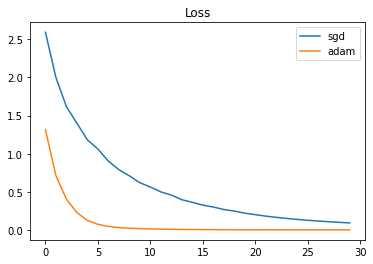

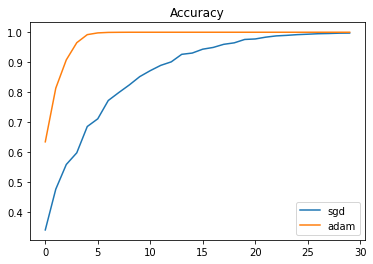

In [39]:
plt.plot(list(range(len(ls_sgd))),ls_sgd,label = "sgd")
plt.plot(list(range(len(ls_adam))),ls_adam,label = "adam")
plt.title("Loss")
plt.legend()
plt.show()

plt.figure()

plt.plot(list(range(len(acc_sgd))),acc_sgd,label = "sgd")
plt.plot(list(range(len(acc_adam))),acc_adam,label = "adam")
plt.title("Accuracy")
plt.legend()
plt.show()

[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'add_2:0' shape=(?, 25) dtype=float32>]
INFO:tensorflow:Restoring parameters from ./model/Adam/simple/2021-11-06T16:47:40
0.80 0.90


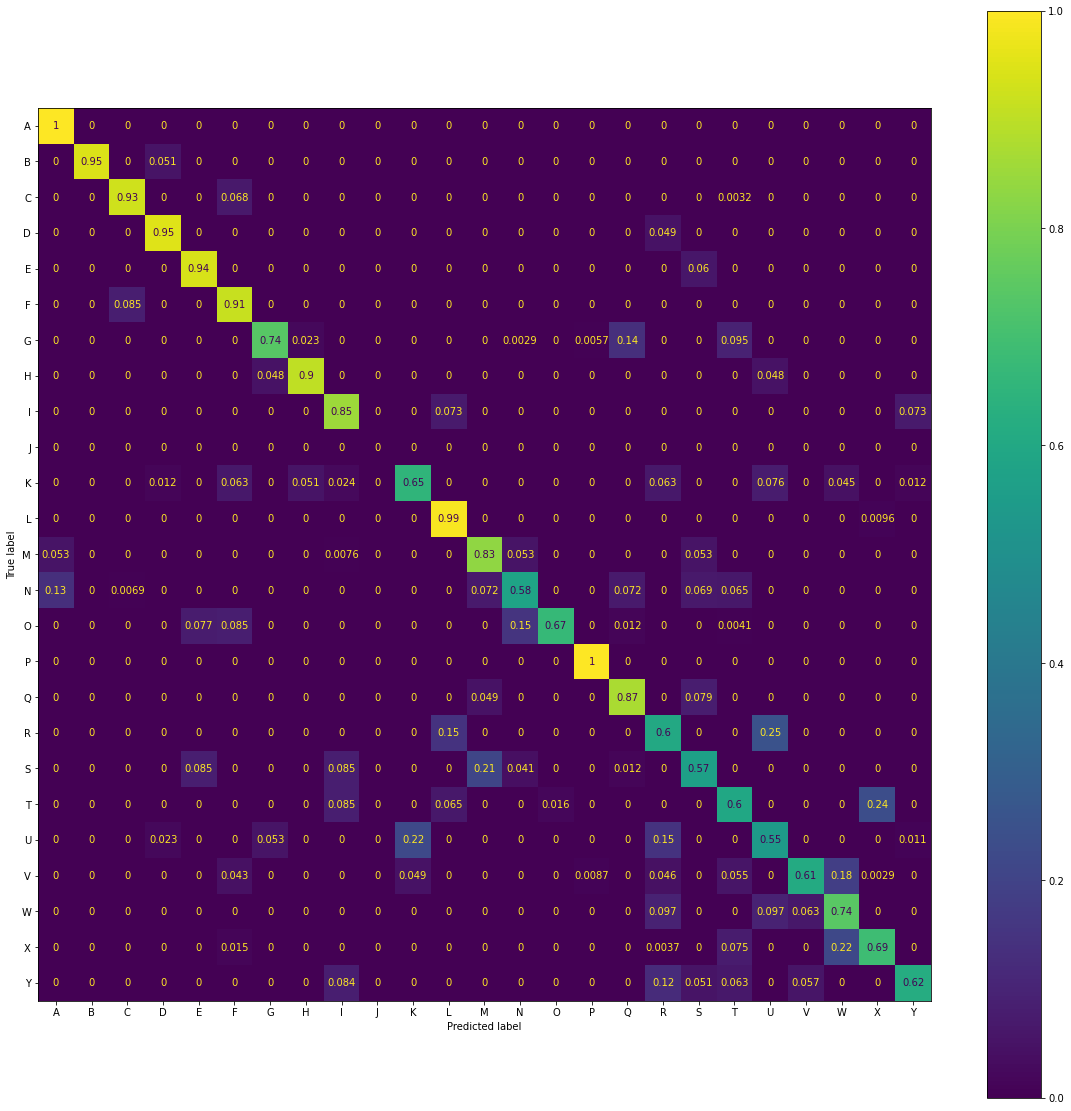

In [146]:
## test of model after save

tf.reset_default_graph()


logits, input_data, out, histogram_tensorboard = neural_network_simple()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
saver = tf.train.Saver()


with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "./model/Adam/simple/{}".format(timestamp))    
    ls,acc = sess.run([Adam_loss,Adam_accuracy],feed_dict={input_data:x_test,out:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(tf.keras.utils.normalize(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(logits,sess,input_data,x_test)[0])),axis=1,order=1),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    

In [76]:
import mediapipe as mp

def live(network,model):
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(static_image_mode=False,
                          max_num_hands=1,
                          min_detection_confidence=0.5,
                          min_tracking_confidence=0.5)

    mpDraw = mp.solutions.drawing_utils

    W = 320
    H = 240

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 0.5
    fontColor              = (255,255,255)
    lineType               = 2

    tf.reset_default_graph()
    logits, input_data, out, histogram_tensorboard = network()

    boundary = 20

    saver = tf.train.Saver()

    with tf.Session().as_default() as sess:
      # Restore variables from disk.
        saver.restore(sess,model)
        cam = cv2.VideoCapture(0)
        print("press ESC to exit")
        try:
            while True:
                ret_val, img = cam.read()
                img = cv2.resize(img, (W,H))        
                results = hands.process(img)

                if results.multi_hand_landmarks:
                    for handLms in results.multi_hand_landmarks:
                        x_max = 0
                        y_max = 0
                        x_min = W
                        y_min = H
                        for id, lm in enumerate(handLms.landmark):
                            #print(id,lm)
                            h, w, c = img.shape
                            cx, cy = int(lm.x *w), int(lm.y*h)
                            #if id ==0:
                            # cv2.circle(img, (cx,cy), 3, (255,0,255), cv2.FILLED)
                            if cx > x_max:
                                x_max = cx
                            if cx < x_min:
                                x_min = cx
                            if cy > y_max:
                                y_max = cy
                            if cy < y_min:
                                y_min = cy
                        frame = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                        x_min -= boundary
                        y_min -= boundary
                        x_max += boundary
                        y_max += boundary

                        x_min = max(0,x_min)
                        y_min = max(0,y_min)
                        frame = frame[y_min:y_max, x_min:x_max]
                        # cv2.imshow("test", frame)
                        frame = cv2.resize(frame, (WIDTH,HEIGHT))

                        frame = 2 * (frame.flatten().astype(np.float32)/255 - 0.5)
                        
                        pred,conf = prediction(logits,sess,input_data,frame.reshape(-1,n_inputs))

                        if pred[0] != 23: ## 23 means nothing
                            cv2.putText(img,"{}-{:.2f}%".format(LABELS[pred[0]],conf[0][0]), 
                                        (x_max,y_max), 
                                        font, 
                                        fontScale,
                                        fontColor,
                                        lineType)
                            # mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)


                cv2.imshow('my webcam', img)


                if cv2.waitKey(1) == 27: 
                    break  # esc to quit
        except Exception as e:
            print(e)
        cam.release()    
        cv2.destroyAllWindows()

In [80]:
live(neural_network_with_BN, "./model/Adam/batchnormal/{}".format(bn_timestamp))

[784, 128, 128, 128, 128, 128, 128, 25]
[<tf.Variable 'W_0:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_3:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_4:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_5:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_6:0' shape=(128, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_3:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_4:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_5:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_6:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_3

In [41]:
## HYPER PARAMS
adam_learning_rate = 0.001
batch_size = 1024
n_inputs = x_train.shape[1]
n_outputs = 25
dropout_layers_num = [n_inputs,256,256,256,256,256,256,n_outputs] ## hidden layers

In [49]:
def neural_network_with_dropout():
    weights = []
    biases = []
    layers = []

    layers_num = dropout_layers_num
    
    tf.reset_default_graph()

    X = tf.placeholder('float', [None, n_inputs])
    Y = tf.placeholder('float', [None, n_outputs])

    histogram_tensorboard = []

    print(layers_num)
    
    for i in range(len(layers_num)-1):
        weights.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i],layers_num[i+1]),name="W_{}".format(i),
                                       initializer=tf.keras.initializers.glorot_normal()))
        histogram_tensorboard.append(tf.summary.histogram("W_{}".format(i), weights[i]))

        biases.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i+1]) , name="B_{}".format(i),
                                      initializer=tf.zeros_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("B_{}".format(i), biases[i]))
    
    
    print(weights)
    print(biases)
    middle = len(layers_num) - 3
    
    layers.append(tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(X, weights[0]), biases[0])), rate = 0.5))
    for i in range(middle):
        layers.append(tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layers[i], weights[i+1]), biases[i+1])), rate = 0.5))
    
    layers.append(tf.matmul(layers[middle], weights[middle+1]) + biases[middle+1])
    
    print(layers)
    return layers[-1],X,Y,histogram_tensorboard

In [43]:
do_timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()

logits, input_data, out, histogram_tensorboard = neural_network_with_dropout()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task("./summary/Adam/dropout/{}".format(do_timestamp),(x_train,y_train),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,180,Adam_train_tensorboard,Adam_merged, input_data, out);

[784, 256, 256, 256, 256, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_3:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_4:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_5:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_6:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_3:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_4:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_5:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_6:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'dropout/Mul_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'dropout_1/Mul_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'dropout_2/Mul_1:0' shape=(?, 256) dtype=f

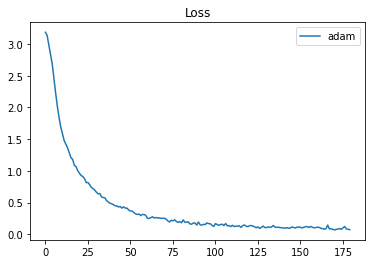

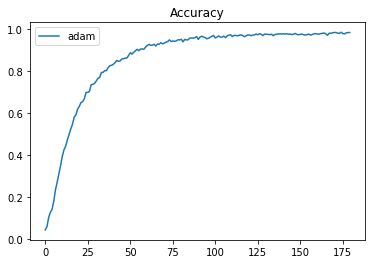

In [46]:
plt.plot(list(range(len(ls_adam))),ls_adam,label = "adam")
plt.title("Loss")
plt.legend()
plt.show()


plt.plot(list(range(len(acc_adam))),acc_adam,label = "adam")
plt.title("Accuracy")
plt.legend()
plt.show()

[784, 256, 256, 256, 256, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_3:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_4:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_5:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_6:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_3:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_4:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_5:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_6:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'dropout/Mul_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'dropout_1/Mul_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'dropout_2/Mul_1:0' shape=(?, 256) dtype=f

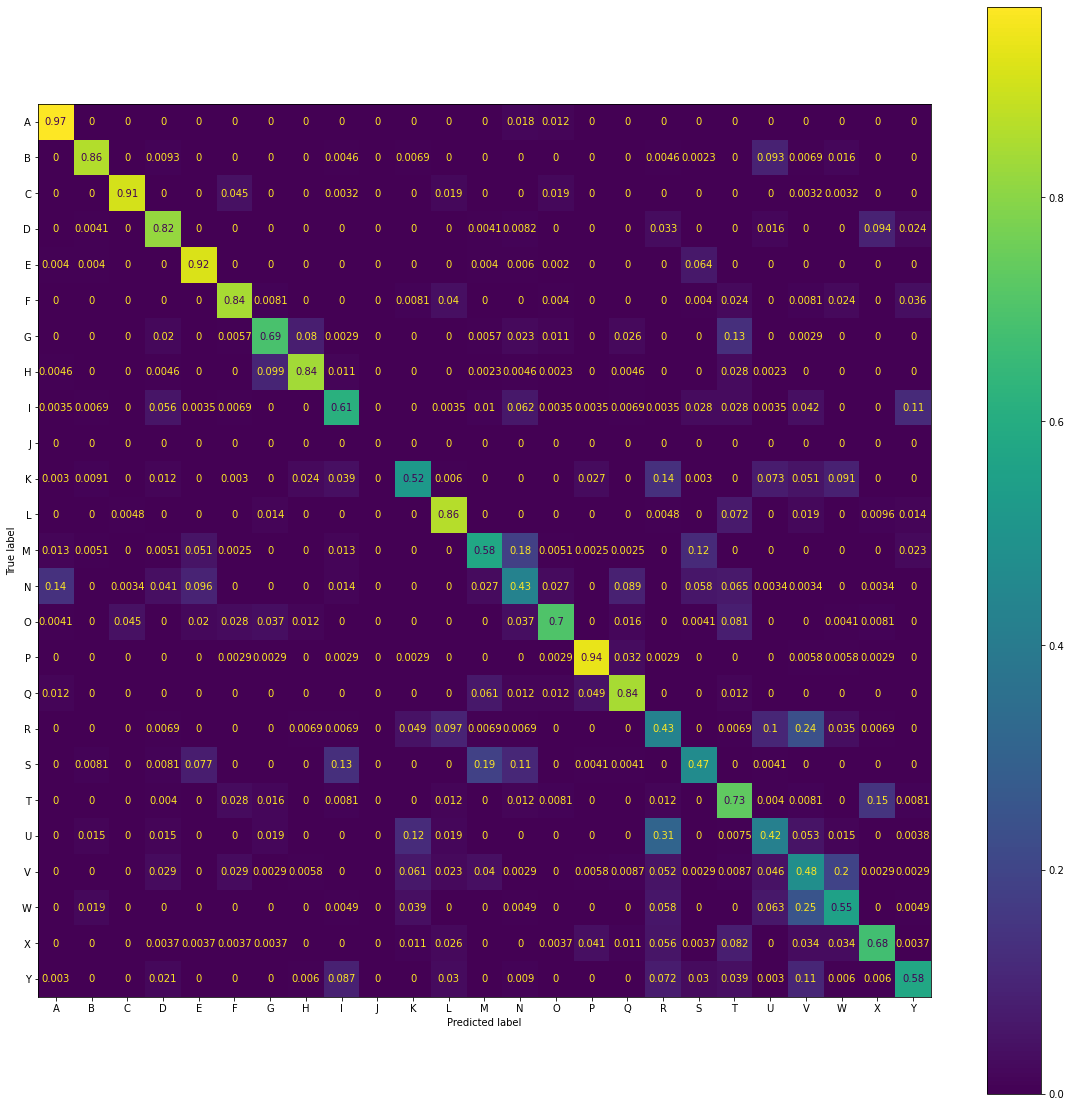

In [147]:
## test of model after save

tf.reset_default_graph()


logits, input_data, out, histogram_tensorboard = neural_network_with_dropout()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})

saver = tf.train.Saver()

with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "./model/Adam/dropout/{}".format(do_timestamp))    
    ls,acc = sess.run([Adam_loss,Adam_accuracy],feed_dict={input_data:x_test,out:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(tf.keras.utils.normalize(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(logits,sess,input_data,x_test)[0])),axis=1,order=1),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    

In [55]:
## HYPER PARAMS
adam_learning_rate = 0.001

batch_size = 1024
n_inputs = x_train.shape[1]
n_outputs = 25
BN_layers_num = [n_inputs,128,128,128,128,128,128,n_outputs] ## hidden layers

train_phase = False

In [56]:
def neural_network_with_BN():
    weights = []
    biases = []
    layers = []
    
    layers_num = BN_layers_num

    tf.reset_default_graph()


    X = tf.placeholder('float', [None, n_inputs])
    Y = tf.placeholder('float', [None, n_outputs])

    histogram_tensorboard = []

    print(layers_num)
    for i in range(len(layers_num)-1):
        weights.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i],layers_num[i+1]),name="W_{}".format(i),
                                       initializer=tf.keras.initializers.glorot_normal()))
        histogram_tensorboard.append(tf.summary.histogram("W_{}".format(i), weights[i]))
        
        biases.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i+1]) , name="B_{}".format(i),
                                      initializer=tf.zeros_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("B_{}".format(i), biases[i]))

    # histogram_merged = tf.summary.merge(histogram_tensorboard)

    print(weights)
    print(biases)
    middle = len(layers_num) - 3
    
    layers.append(tf.nn.relu(tf.layers.batch_normalization(tf.add(tf.matmul(X, weights[0]), biases[0]), training = train_phase)))
    
    for i in range(middle):
        layers.append(tf.nn.relu(tf.layers.batch_normalization(tf.add(tf.matmul(layers[i], weights[i+1]), biases[i+1]), training = train_phase)))

    layers.append(tf.matmul(layers[middle], weights[middle+1]) + biases[middle+1])
    # layers.append(tf.matmul(layers[2], weights[3]))

    print(layers)
    return layers[-1],X,Y,histogram_tensorboard

In [60]:
bn_timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()

logits, input_data, out, histogram_tensorboard = neural_network_with_BN()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task("./summary/Adam/batchnormal/{}".format(bn_timestamp),(x_train,y_train),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,76,Adam_train_tensorboard,Adam_merged, input_data, out);

[784, 128, 128, 128, 128, 128, 128, 25]
[<tf.Variable 'W_0:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_3:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_4:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_5:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_6:0' shape=(128, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_3:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_4:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_5:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_6:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_3

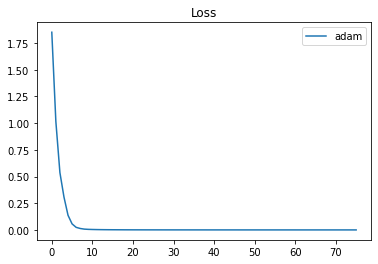

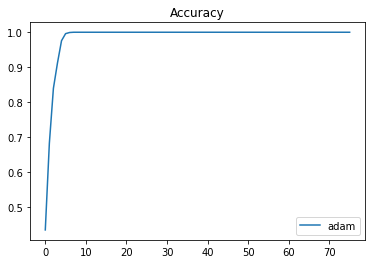

In [58]:
plt.plot(list(range(len(ls_adam))),ls_adam,label = "adam")
plt.title("Loss")
plt.legend()
plt.show()


plt.plot(list(range(len(acc_adam))),acc_adam,label = "adam")
plt.title("Accuracy")
plt.legend()
plt.show()


[784, 128, 128, 128, 128, 128, 128, 25]
[<tf.Variable 'W_0:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_3:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_4:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_5:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'W_6:0' shape=(128, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_3:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_4:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_5:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'B_6:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Relu_3

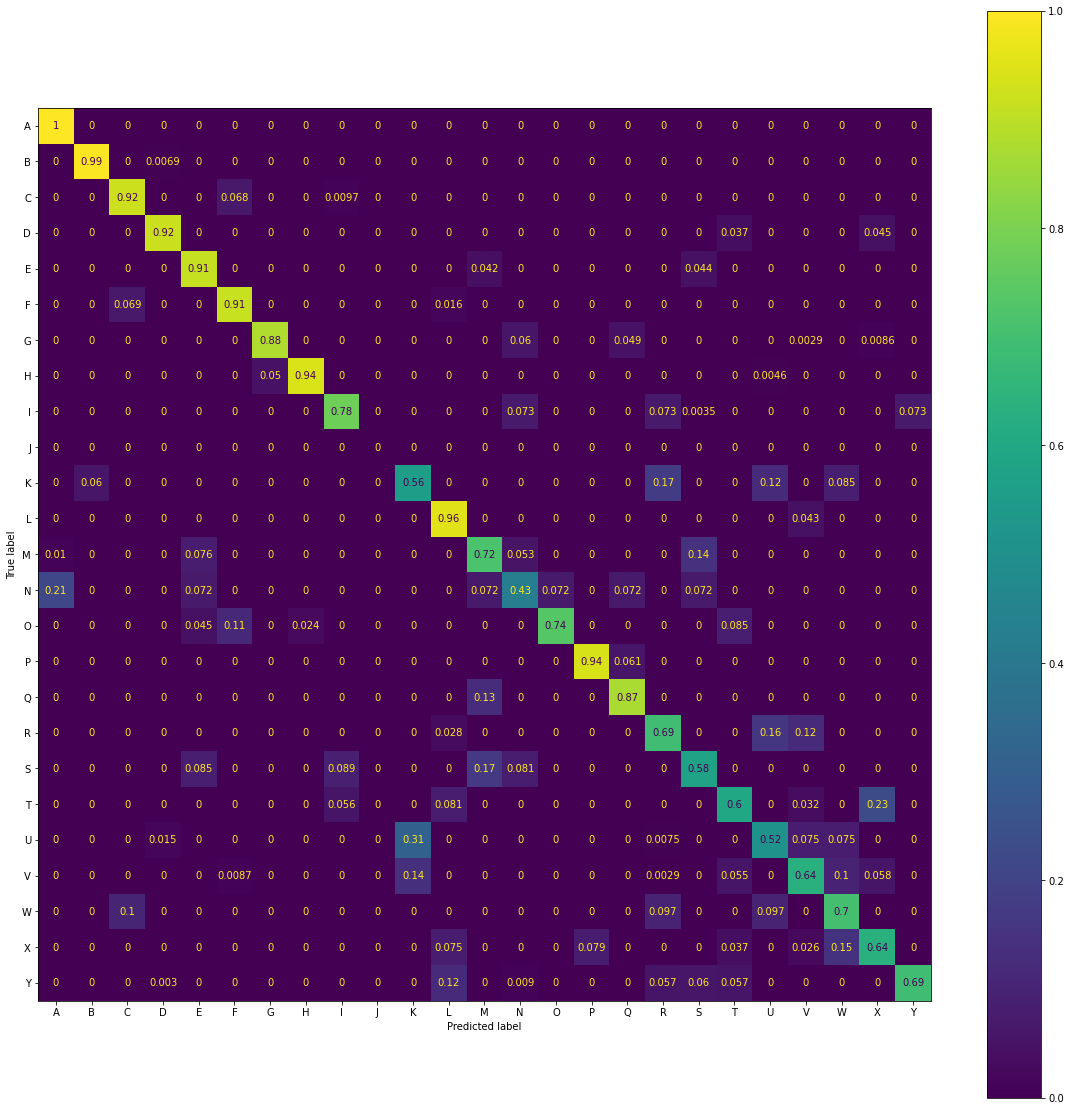

In [148]:
## test of model after save

tf.reset_default_graph()


logits, input_data, out, histogram_tensorboard = neural_network_with_BN()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
saver = tf.train.Saver()

with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "./model/Adam/batchnormal/{}".format(bn_timestamp))    
    ls,acc = sess.run([Adam_loss,Adam_accuracy],feed_dict={input_data:x_test,out:y_test})
    print(acc,"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(tf.keras.utils.normalize(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(logits,sess,input_data,x_test)[0])),axis=1,order=1), display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax) 
    

In [85]:
idx = np.random.randint(0,train_data_length, int(train_data_length/5) )
x_subsample = np.take(x_train, idx, axis=0)
y_subsample = np.take(y_train, idx, axis=0)


In [92]:
ss_timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()

logits, input_data, out, histogram_tensorboard = neural_network_simple()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task("./summary/Adam/subsample/{}".format(ss_timestamp),(x_subsample,y_subsample),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,150,Adam_train_tensorboard,Adam_merged, input_data, out);

[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'add_2:0' shape=(?, 25) dtype=float32>]
--------------------------------------------------
Epoch:0 	 Validation Loss:2.62 , acc: 0.24
--------------------------------------------------
--------------------------------------------------
Epoch:25 	 Validation Loss:1.49 , acc: 0.55
--------------------------------------------------
--------------------------------------------------
Epoch:50 	 Validation Loss:0.65 , acc: 0.80
--------------------------------------------------
--------------------------------------------------


[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'add_2:0' shape=(?, 25) dtype=float32>]
INFO:tensorflow:Restoring parameters from ./model/Adam/subsample/2021-11-06T17:29:05
0.80660903 0.94


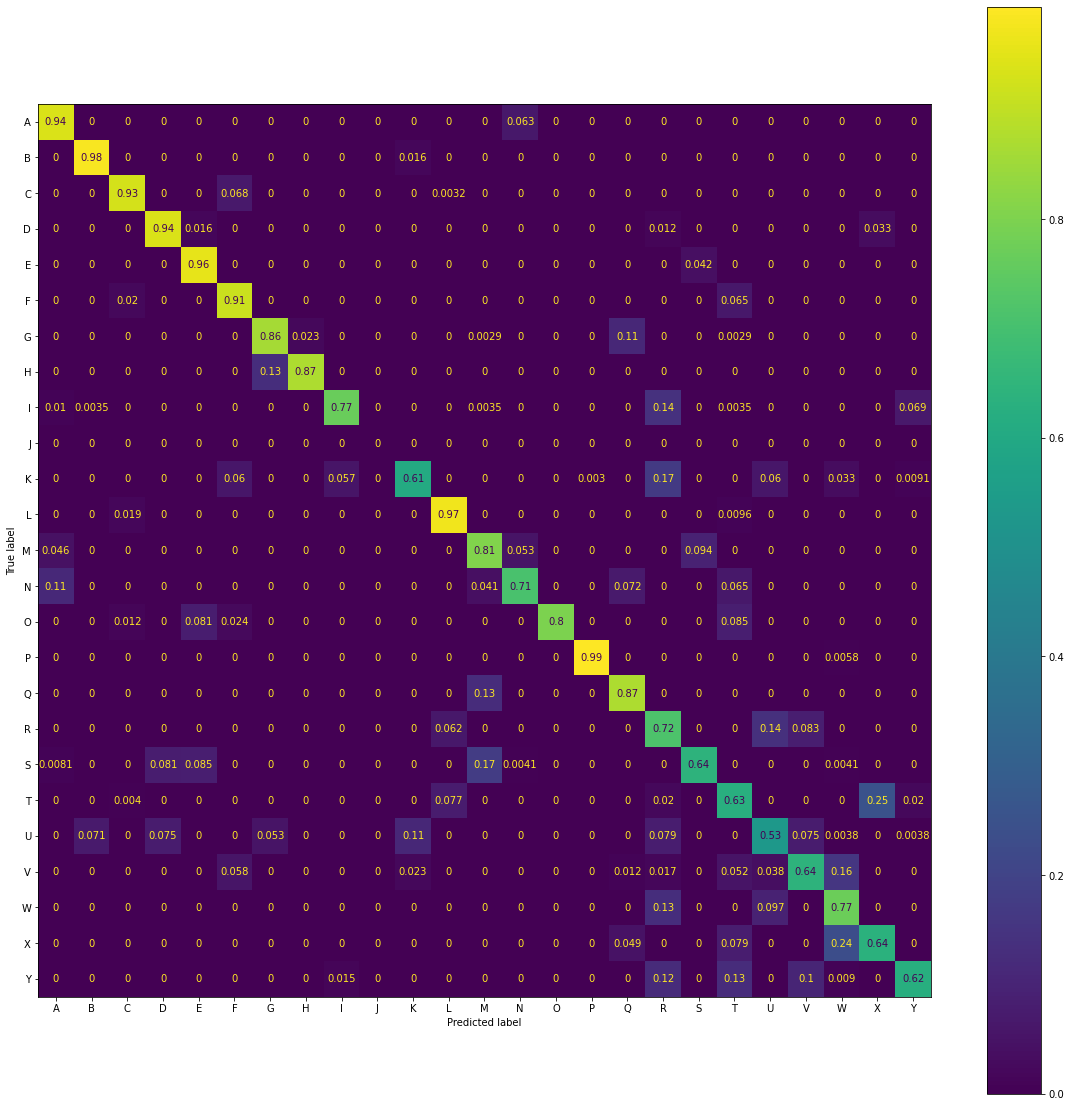

In [149]:
## test of model after save

tf.reset_default_graph()


logits, input_data, out, histogram_tensorboard = neural_network_simple()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
saver = tf.train.Saver()

with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "./model/Adam/subsample/{}".format(ss_timestamp))    
    ls,acc = sess.run([Adam_loss,Adam_accuracy],feed_dict={input_data:x_test,out:y_test})
    print(acc,"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(tf.keras.utils.normalize(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(logits,sess,input_data,x_test)[0])),axis=1,order=1), display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    